In [1]:
from google.colab import drive,output
drive.mount('/content/drive')           ### Su

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip drive/MyDrive/datasets/optic_disc/train.zip -d train
output.clear()

In [3]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.applications.vgg16 import preprocess_input as pi
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
!pip install git+https://github.com/tensorflow/examples.git
!pip install segmentation_models

output.clear()


In [4]:
!export SM_FRAMEWORK=tf.keras
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [5]:
img_h=256
img_w=256


In [6]:
import glob
import cv2
import os
images_t = glob.glob("train/train/*.jpeg")
labels_t=pd.read_csv('drive/MyDrive/datasets/optic_disc/trainLabels.csv')

In [7]:
train_img=np.zeros((len(images_t),img_h,img_w,3),dtype=np.uint8)
# train_label=np.zeros((len(images_t),5),dtype=np.uint8)
train_label=np.zeros((len(images_t)))

In [8]:
limit={
    0:0,
    1:0,
    2:0,
    3:0,
    4:0
}

In [9]:
n=0
for i,id in tqdm(enumerate(images_t),total=len(images_t)):
  name=((id.split('/'))[-1])[:-5]
  # if limit[(labels_t[(labels_t.image==name)])['level'].values[0]]>=220:
  #   continue
  # limit[(labels_t[(labels_t.image==name)])['level'].values[0]]+=1
  img=load_img(id,target_size=(img_h,img_w))
  img=img_to_array(img)
  train_img[n]=img
  train_label[n]=(labels_t[(labels_t.image==name)])['level'].values[0]
  n+=1
  # train_label[i][(labels_t[(labels_t.image==name)])['level'].values[0]]=(labels_t[(labels_t.image==name)])['level'].values[0]

100%|██████████| 1427/1427 [01:51<00:00, 12.85it/s]


In [10]:
t_x=train_img
t_y=train_label

(array([1017.,    0.,  112.,    0.,    0.,  230.,    0.,   32.,    0.,
          36.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

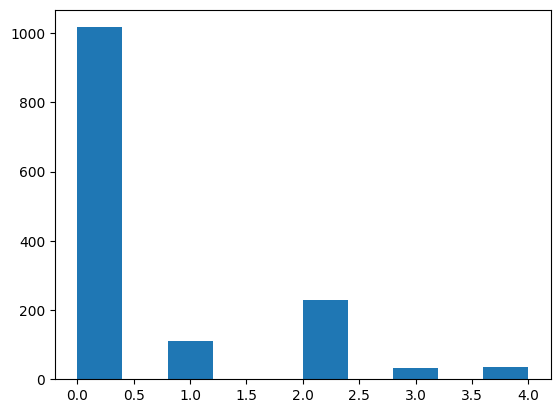

In [11]:
plt.hist(train_label)

In [12]:
from keras.utils import to_categorical
train_label=to_categorical(train_label, 5)
train_img = train_img.astype("float32")/255.

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_img, train_label, test_size = 0.1, random_state = 42)


print(np.array(x_train).shape)
print(np.array(y_train).shape)


(1284, 256, 256, 3)
(1284, 5)


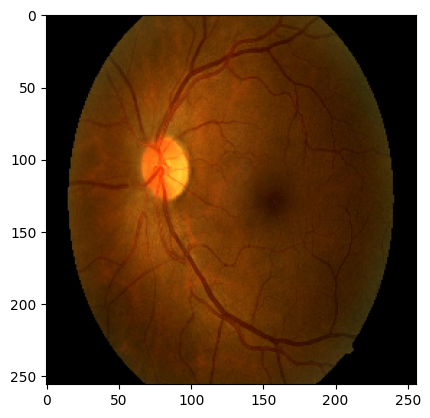

In [14]:
plt.imshow(x_train[0])

In [14]:
from keras.preprocessing.image import ImageDataGenerator
X_train = x_train
Y_train = y_train
shift = 0.2
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=360,
    width_shift_range=shift,
    height_shift_range=shift, shear_range=0.2,
    zoom_range=0.2, channel_shift_range=4.,
    horizontal_flip=True, vertical_flip=True,
    rescale=1. /255,
    fill_mode='nearest')

datagen.fit(x_train)



# Concatenating the old data with the augmented data
train_x  = np.concatenate((x_train, X_train), axis=0)
train_y  = np.concatenate((y_train, Y_train), axis=0)
print(train_x.shape)
print(train_y.shape)

(2568, 256, 256, 3)
(2568, 5)


In [15]:
from keras import backend as K
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [16]:
from keras.applications import InceptionResNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Input
from keras.applications import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications import MobileNet
from keras.applications import InceptionResNetV2

def create_model(input_shape, n_out):
    pretrain_model = PTModel(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape)
    input_tensor = Input(input_shape)
    c0 = BatchNormalization()(input_tensor)
    c1= pretrain_model(c0)
    # c1=GlobalAveragePooling2D()(c1)

    c1 = Conv2D(128,3, activation='relu')(c1)
    c1 = Flatten()(c1)
    c1 = Dropout(0.4)(c1)
    c1 = Dense(256, activation='relu')(c1)
    c1 = Dropout(0.4)(c1)
    output = Dense(n_out, activation='softmax')(c1)
    model = Model(input_tensor, output)

    return model

-----------VGG16-----------

In [32]:
# from keras.applications.vgg16 import VGG16 as PTModel

# vgg16_model=create_model((img_h,img_w,3),5)
# vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),loss='categorical_crossentropy',metrics=['accuracy',f1])
# vgg16_model.summary()
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# mp=ModelCheckpoint('best_seg_model.h5',save_best_only=True,monitor='val_accuracy')
# call=[mp]


# history=vgg16_model.fit(
#     train_x,
#     train_y,
#     # validation_data=(x_test,y_test),
#     validation_split=0.1,
#     batch_size=1,
#     # steps_per_epoch=100,
#     epochs=10,
#     callbacks=call
# )

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 batch_normalization_3 (Bat  (None, 256, 256, 3)       12        
 chNormalization)                                                
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 128)         589952    
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout_2 (Dropout)         (None, 4608)              0         
                                                           

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2311/2311 [==============================] - 106s 38ms/step - loss: 1.0443 - accuracy: 0.7122 - f1: 0.1277 - val_loss: 0.8338 - val_accuracy: 0.7432 - val_f1: 0.1402
Epoch 2/10
2311/2311 [==============================] - 86s 37ms/step - loss: 0.9487 - accuracy: 0.7200 - f1: 0.1291 - val_loss: 0.8781 - val_accuracy: 0.7432 - val_f1: 0.1435
Epoch 3/10
2311/2311 [==============================] - 85s 37ms/step - loss: 1.0015 - accuracy: 0.7196 - f1: 0.1291 - val_loss: 0.8403 - val_accuracy: 0.7432 - val_f1: 0.1413
Epoch 4/10
2311/2311 [==============================] - 85s 37ms/step - loss: 1.1009 - accuracy: 0.7192 - f1: 0.1289 - val_loss: 0.8347 - val_accuracy: 0.7432 - val_f1: 0.1395
Epoch 5/10
2311/2311 [==============================] - 84s 36ms/step - loss: 0.9448 - accuracy: 0.7196 - f1: 0.1296 - val_loss: 0.8536 - val_accuracy: 0.7432 - val_f1: 0.1297
Epoch 6/10
2311/2311 [==============================] - 84s 36ms/step - loss: 0.9334 - accuracy: 0.7196 - f1: 0.1296 - val_loss: 0

--------InceptionResnet50--------

In [17]:
from keras.applications.resnet50 import ResNet50 as PTModel

inceptionResnet_model=create_model((img_h,img_w,3),5)
inceptionResnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),loss='categorical_crossentropy',metrics=['accuracy',f1])
inceptionResnet_model.summary()
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
mp=ModelCheckpoint('best_seg_model.h5',save_best_only=True,monitor='val_accuracy')
call=[mp]


history=inceptionResnet_model.fit(
    train_x,
    train_y,
    # validation_data=(x_test,y_test),
    validation_split=0.1,
    batch_size=1,
    # steps_per_epoch=100,
    epochs=15,
    callbacks=call
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 3)       12        
 Normalization)                                                  
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 128)         2359424   
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2311/2311 [==============================] - 163s 45ms/step - loss: 1.3028 - accuracy: 0.6486 - f1: 0.1246 - val_loss: 1.0759 - val_accuracy: 0.7315 - val_f1: 0.1062
Epoch 2/15
2311/2311 [==============================] - 102s 44ms/step - loss: 1.0310 - accuracy: 0.7032 - f1: 0.1279 - val_loss: 0.9220 - val_accuracy: 0.7432 - val_f1: 0.1375
Epoch 3/15
2311/2311 [==============================] - 99s 43ms/step - loss: 1.0177 - accuracy: 0.7032 - f1: 0.1297 - val_loss: 0.9949 - val_accuracy: 0.7354 - val_f1: 0.1142
Epoch 4/15
2311/2311 [==============================] - 99s 43ms/step - loss: 0.9945 - accuracy: 0.7166 - f1: 0.1300 - val_loss: 4.4221 - val_accuracy: 0.5992 - val_f1: 0.1172
Epoch 5/15
2311/2311 [==============================] - 100s 43ms/step - loss: 1.0315 - accuracy: 0.7127 - f1: 0.1286 - val_loss: 5.2303 - val_accuracy: 0.7237 - val_f1: 0.1380
Epoch 6/15
2311/2311 [==============================] - 99s 43ms/step - loss: 1.0100 - accuracy: 0.7187 - f1: 0.1283 - val_loss:

In [17]:
from keras.applications.densenet import DenseNet121 as PTModel
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

DenseNet_model=create_model((img_h,img_w,3),5)
DenseNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),loss='categorical_crossentropy',metrics=['accuracy',f1])
DenseNet_model.summary()

es = EarlyStopping( monitor = 'accuracy', mode = 'max', min_delta = 1,patience = 5,restore_best_weights = True,verbose = 2)  #'''min_delta = 1,patience = 20,'''
checkpoint_path = "DenseNet/cp.ckpt"

mp=ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,verbose=1)
call=[mp,es]


history=DenseNet_model.fit(
    train_x,
    train_y,
    # validation_data=(x_test,y_test),
    validation_split=0.1,
    batch_size=1,
    # steps_per_epoch=100,
    epochs=10,
    callbacks=call
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 batch_normalization_1 (Bat  (None, 256, 256, 3)       12        
 chNormalization)                                                
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 128)         1179776   
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dropout_2 (Dropout)         (None, 4608)              0         
                                                           

In [18]:
score = DenseNet_model.evaluate(x_test, y_test,  verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.0360603332519531
Test accuracy: 0.6293706297874451


In [17]:
from keras.applications.xception import Xception as PTModel
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

xception_model=create_model((img_h,img_w,3),5)
xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),loss='categorical_crossentropy',metrics=['accuracy',f1])
xception_model.summary()

es = EarlyStopping( monitor = 'accuracy', mode = 'max', min_delta = 1,patience = 7,restore_best_weights = True,verbose = 2)  #'''min_delta = 1,patience = 20,'''
checkpoint_path = "DenseNet/cp.ckpt"

mp=ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,verbose=1)
call=[mp,es]


history=xception_model.fit(
    train_x,
    train_y,
    # validation_data=(x_test,y_test),
    validation_split=0.1,
    batch_size=1,
    # steps_per_epoch=100,
    epochs=10,
    callbacks=call
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 batch_normalization_4 (Bat  (None, 256, 256, 3)       12        
 chNormalization)                                                
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 128)         2359424   
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                             

In [2]:
score = xception_model.evaluate(train_x, train_y,  verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.5346979904174805
Test accuracy: 0.7463706297874451
